In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

In [2]:
df_scraping = pd.read_csv('filtered_data.csv')
df_scraping = df_scraping.dropna()
# Step 2: Convert 'date' column to datetime
df_scraping['date'] = pd.to_datetime(df_scraping['standard_date'])

# Step 3: Extract year and month from 'date'
df_scraping['year'] = df_scraping['date'].dt.year
df_scraping['month'] = df_scraping['date'].dt.month

# Step 4: Create geometry column from longitude and latitude
df_scraping['geometry'] = df_scraping.apply(lambda row: Point(row['lon'], row['lat']), axis=1)

# Step 5: Convert DataFrame to GeoDataFrame
gdf_scraping = gpd.GeoDataFrame(df_scraping, geometry='geometry')

# Step 6: Set coordinate reference system to WGS84
gdf_scraping.set_crs(epsg=4326, inplace=True)

# Optional: Read Mexico City shapefile for map overlay (if available)
city_map = gpd.read_file('poligonos_alcaldias_cdmx')
gdf_scraping = gpd.clip(gdf_scraping, city_map)

start_date = pd.to_datetime('2019-02-01')
end_date = pd.to_datetime('2024-11-01')
gdf_scraping = gdf_scraping[(gdf_scraping['date'] >= start_date) & (gdf_scraping['date'] < end_date)]

In [3]:
filtered_chunks = []
for chunk in pd.read_csv('fiscalia.csv', chunksize=10000):
    filtered_chunk = chunk[chunk['categoria_delito'].isin([
    'HOMICIDIO DOLOSO',
    'LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO',
    'FEMINICIDIO'
    ])]
    filtered_chunks.append(filtered_chunk)

df_fiscalia = pd.concat(filtered_chunks, ignore_index=True)
df_fiscalia = df_fiscalia.dropna()
# Step 2: Convert 'date' column to datetime
df_fiscalia['date'] = pd.to_datetime(df_fiscalia['fecha_inicio'])

# Step 3: Extract year and month from 'date'
df_fiscalia['year'] = df_fiscalia['date'].dt.year
df_fiscalia['month'] = df_fiscalia['date'].dt.month

# Step 4: Create geometry column from longitude and latitude
df_fiscalia['geometry'] = df_fiscalia.apply(lambda row: Point(row['longitud'], row['latitud']), axis=1)

# Step 5: Convert DataFrame to GeoDataFrame
gdf_fiscalia = gpd.GeoDataFrame(df_fiscalia, geometry='geometry')

# Step 6: Set coordinate reference system to WGS84
gdf_fiscalia.set_crs(epsg=4326, inplace=True)
gdf_fiscalia = gpd.clip(gdf_fiscalia, city_map)

start_date = pd.to_datetime('2020-09-01')
end_date = pd.to_datetime('2024-11-01')
gdf_fiscalia = gdf_fiscalia[(gdf_fiscalia['date'] >= start_date) & (gdf_fiscalia['date'] < end_date)]

In [4]:
def plot_time_series_crimes_per_month(gdf):
    # Group data by year and month, then count the number of crimes
    gdf['year_month'] = gdf['date'].dt.to_period('M')  # Create a year-month period column
    crime_counts_per_month = gdf.groupby('year_month').size().reset_index(name='crime_count')
    crime_counts_per_month['year_month'] = crime_counts_per_month['year_month'].astype(str)  # Convert to string for plotting

    # Plot the time series
    plt.figure(figsize=(14, 7))
    plt.plot(crime_counts_per_month['year_month'], crime_counts_per_month['crime_count'], marker='o', linestyle='-', color='blue')
    plt.title('Time Series of Crimes per Month in Mexico City - Scrapping')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Crimes')
    plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()

In [5]:
def analyze_time_series_crimes_per_month(gdf):
    gdf_filtered = gdf.copy()
    # Group data by year and month, then count the number of crimes
    gdf_filtered['year_month'] = gdf_filtered['date'].dt.to_period('M')  # Create a year-month period column
    crime_counts_per_month = gdf_filtered.groupby('year_month').size().reset_index(name='crime_count')

    # Set 'year_month' as the index
    crime_counts_per_month.set_index('year_month', inplace=True)

    # Ensure the index has a frequency
    crime_counts_per_month.index = crime_counts_per_month.index.to_timestamp()
    crime_counts_per_month = crime_counts_per_month.asfreq('MS')  # 'MS' stands for Month Start

    # Handle missing data by interpolating
    crime_counts_per_month['crime_count'].interpolate(method='linear', inplace=True)

    # Perform seasonal decomposition
    result = seasonal_decompose(crime_counts_per_month['crime_count'], model='multiplicative')

    # Extract the components
    observed = result.observed
    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid

    # Create a figure with four subplots
    fig, axs = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

    # Plot observed data
    axs[0].plot(crime_counts_per_month.index, observed, label='Observed', color='blue')
    axs[0].set_title('Observed')
    axs[0].legend(loc='upper left')

    # Plot trend component
    axs[1].plot(crime_counts_per_month.index, trend, label='Trend', color='orange')
    axs[1].set_title('Trend')
    axs[1].legend(loc='upper left')

    # Plot seasonal component
    axs[2].plot(crime_counts_per_month.index, seasonal, label='Seasonal', color='green')
    axs[2].set_title('Seasonal')
    axs[2].legend(loc='upper left')

    # Plot residuals
    axs[3].plot(crime_counts_per_month.index, residual, label='Residual', color='red')
    axs[3].set_title('Residual')
    axs[3].legend(loc='upper left')

    # Format the x-axis to show months
    locator = mdates.MonthLocator(interval=1)  # Adjust interval if needed
    formatter = mdates.DateFormatter('%Y-%m')

    for ax in axs:
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        ax.tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

    # Optionally return the decomposition result
    return result

/tmp/ipykernel_43861/1408926508.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  crime_counts_per_month['crime_count'].interpolate(method='linear', inplace=True)
/tmp/ipykernel_43861/1408926508.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].

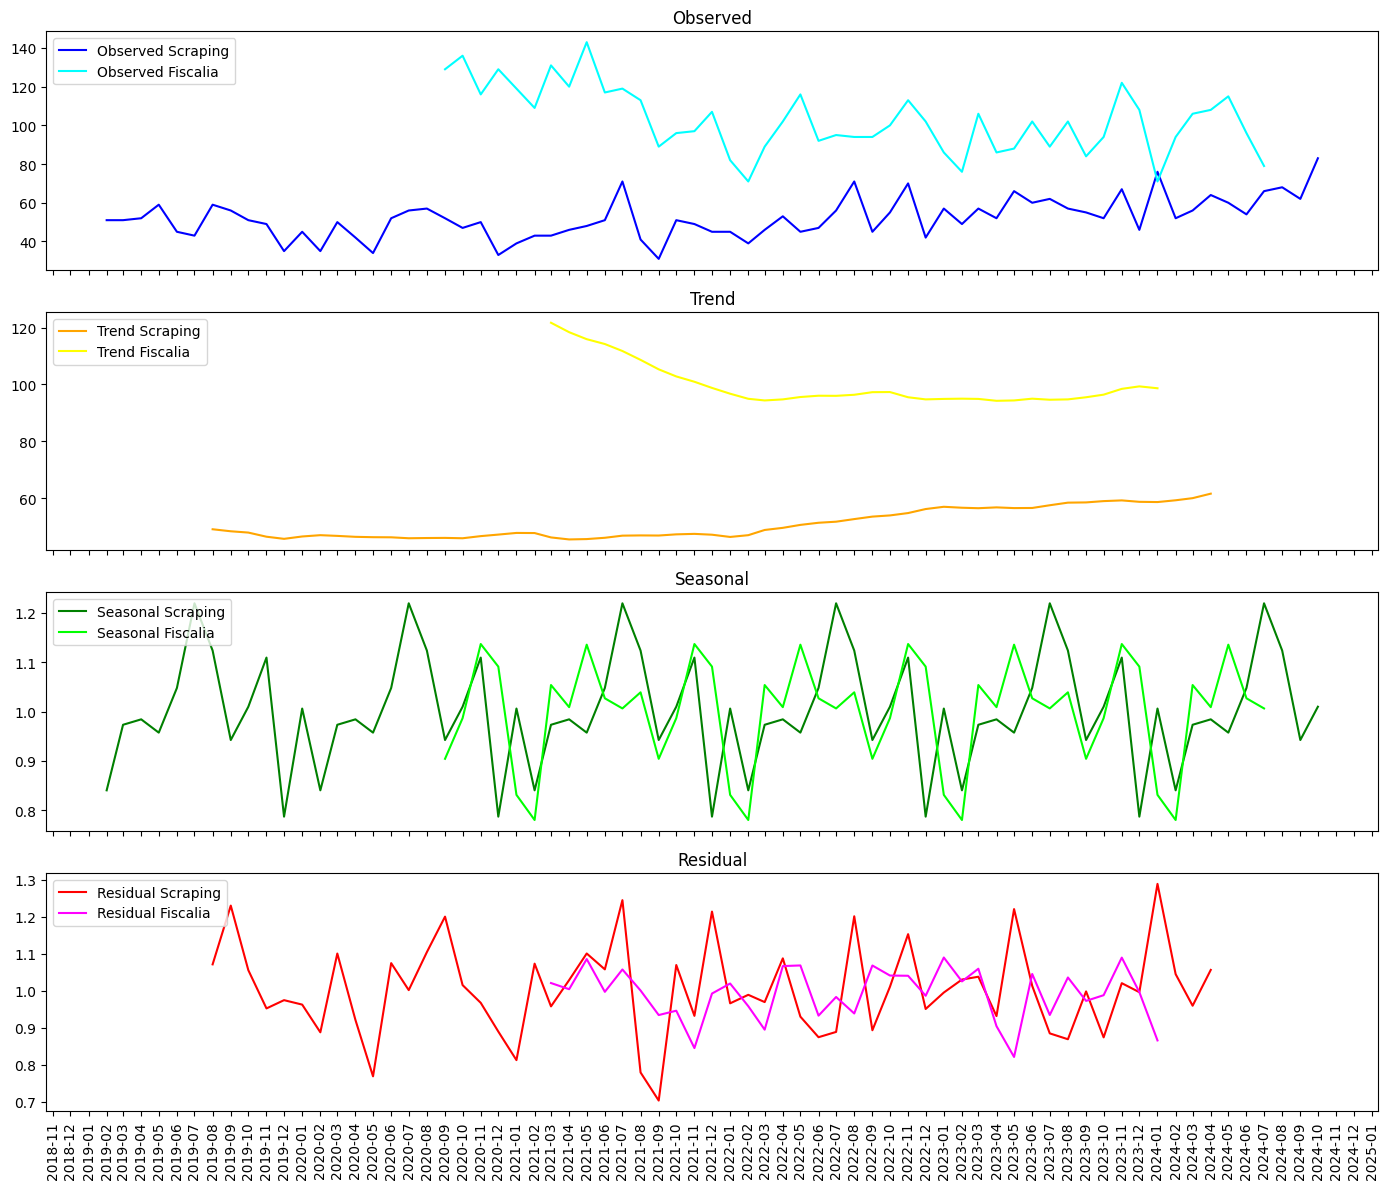

(<statsmodels.tsa.seasonal.DecomposeResult at 0x7f1b8b27bc70>,
 <statsmodels.tsa.seasonal.DecomposeResult at 0x7f1b8b27ba30>)

In [9]:
def analyze_time_series_crimes_per_month(gdf1, gdf2):
    def prepare_data(gdf):
        gdf_filtered = gdf.copy()
        gdf_filtered['year_month'] = gdf_filtered['date'].dt.to_period('M')
        crime_counts_per_month = gdf_filtered.groupby('year_month').size().reset_index(name='crime_count')
        crime_counts_per_month.set_index('year_month', inplace=True)
        crime_counts_per_month.index = crime_counts_per_month.index.to_timestamp()
        crime_counts_per_month = crime_counts_per_month.asfreq('MS')
        crime_counts_per_month['crime_count'].interpolate(method='linear', inplace=True)
        return crime_counts_per_month

    crime_counts_per_month1 = prepare_data(gdf1)
    crime_counts_per_month2 = prepare_data(gdf2)

    result1 = seasonal_decompose(crime_counts_per_month1['crime_count'], model='multiplicative')
    result2 = seasonal_decompose(crime_counts_per_month2['crime_count'], model='multiplicative')

    fig, axs = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

    axs[0].plot(crime_counts_per_month1.index, result1.observed, label='Observed Scraping', color='blue')
    axs[0].plot(crime_counts_per_month2.index, result2.observed, label='Observed Fiscalia', color='cyan')
    axs[0].set_title('Observed')
    axs[0].legend(loc='upper left')

    axs[1].plot(crime_counts_per_month1.index, result1.trend, label='Trend Scraping', color='orange')
    axs[1].plot(crime_counts_per_month2.index, result2.trend, label='Trend Fiscalia', color='yellow')
    axs[1].set_title('Trend')
    axs[1].legend(loc='upper left')

    axs[2].plot(crime_counts_per_month1.index, result1.seasonal, label='Seasonal Scraping', color='green')
    axs[2].plot(crime_counts_per_month2.index, result2.seasonal, label='Seasonal Fiscalia', color='lime')
    axs[2].set_title('Seasonal')
    axs[2].legend(loc='upper left')

    axs[3].plot(crime_counts_per_month1.index, result1.resid, label='Residual Scraping', color='red')
    axs[3].plot(crime_counts_per_month2.index, result2.resid, label='Residual Fiscalia', color='magenta')
    axs[3].set_title('Residual')
    axs[3].legend(loc='upper left')

    locator = mdates.MonthLocator(interval=1)
    formatter = mdates.DateFormatter('%Y-%m')

    for ax in axs:
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        ax.tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

    return result1, result2

analyze_time_series_crimes_per_month(gdf_scraping, gdf_fiscalia)



/tmp/ipykernel_43861/1408926508.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  crime_counts_per_month['crime_count'].interpolate(method='linear', inplace=True)
/tmp/ipykernel_43861/1408926508.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].

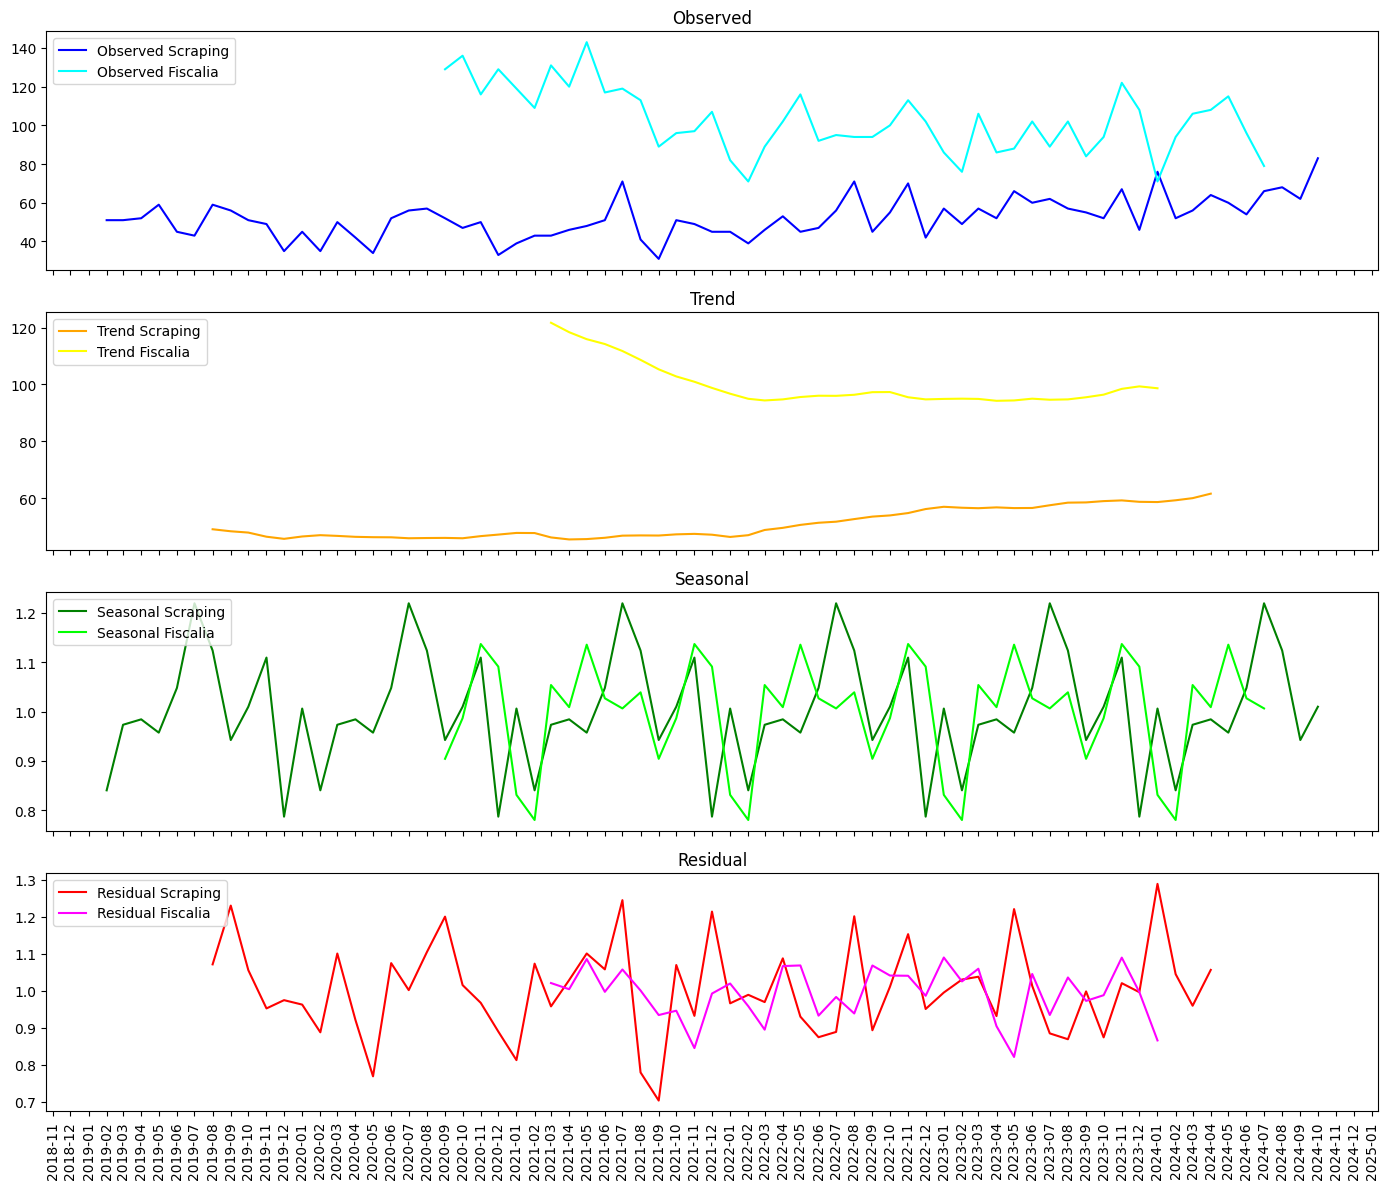

Correlation between observed components: -0.1838251621829302
Correlation between trend components: -0.6386787188275772
Correlation between seasonal components: 0.2364048897300977
Correlation between residual components: -0.04067354940548037


In [16]:
# Let's use .corr method to calculate the correlation between the two time series for
# observed, trend, seasonal, and residual components without plotting the data.
result1, result2 = analyze_time_series_crimes_per_month(gdf_scraping, gdf_fiscalia)
observed_corr = result1.observed.corr(result2.observed)
trend_corr = result1.trend.corr(result2.trend)
seasonal_corr = result1.seasonal.corr(result2.seasonal)
residual_corr = result1.resid.corr(result2.resid)

print(f'Correlation between observed components: {observed_corr}')
print(f'Correlation between trend components: {trend_corr}')
print(f'Correlation between seasonal components: {seasonal_corr}')
print(f'Correlation between residual components: {residual_corr}')




